In [1]:
import xgboost as xgb
import awkward as ak
import matplotlib.pyplot as plt
import hist
import warnings
import pickle
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json
import numpy as np
import pickle

In [ ]:
warnings.filterwarnings('ignore', 'invalid value')
warnings.filterwarnings('ignore', 'No format')
warnings.filterwarnings('ignore', 'overflow encountered in exp')

In [48]:
ratios = 100

In [49]:
with open(f'sub_ratios/{ratios}.pkl', 'rb') as f:
    feature_names = pickle.load(f)

In [50]:
columns = [f'train_ratios.{i}' for i in feature_names].append('goodjets')

In [51]:
hgg = ak.from_parquet('/scratch365/cmoore24/training/hgg/batch2025/inputs/test/hgg.parquet', columns=columns)
qcd = ak.from_parquet('/scratch365/cmoore24/training/hgg/batch2025/inputs/test/qcd.parquet', columns=columns)

In [52]:
# feature_names = qcd.train_ratios.fields

In [53]:
path = f'/scratch365/cmoore24/training/hgg/batch2025/outputs/bdt/{ratios}'

In [54]:
bst = xgb.Booster()
bst.load_model(f'{path}/bdt_model.json')

In [55]:
scaler = f'{path}/scaler.pkl'
with open(scaler, 'rb') as f:
    scaler = pickle.load(f)

In [56]:
hgg_np = np.column_stack([ak.to_numpy(hgg.train_ratios[feature]) for feature in feature_names])
qcd_np = np.column_stack([ak.to_numpy(qcd.train_ratios[feature]) for feature in feature_names])

In [57]:
len(feature_names)

100

In [58]:
hgg_np = scaler.transform(hgg_np)
qcd_np = scaler.transform(qcd_np)

In [59]:
hgg_xgb = xgb.DMatrix(hgg_np, feature_names=feature_names)
qcd_xgb = xgb.DMatrix(qcd_np, feature_names=feature_names)

In [60]:
hgg['hgg_scores'] = bst.predict(hgg_xgb)
qcd['qcd_scores'] = bst.predict(qcd_xgb)

In [61]:
# bst.get_score(importance_type="gain")

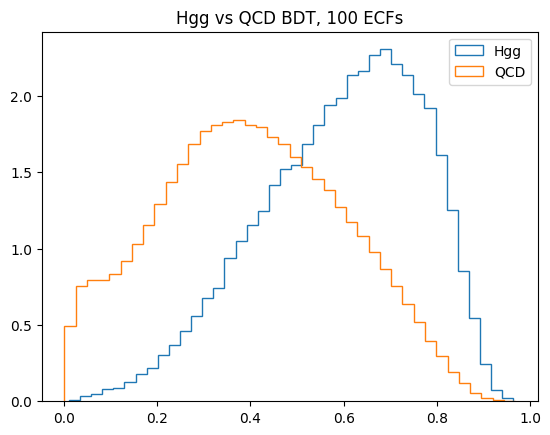

In [62]:
plt.hist(hgg.hgg_scores, bins=40, histtype='step', label='Hgg', density=True)
plt.hist(qcd.qcd_scores, bins=40, histtype='step', label='QCD', density=True)
plt.title(f'Hgg vs QCD BDT, {ratios} ECFs')
plt.legend()
plt.show()

In [16]:
mask = ~np.isnan(qcd.qcd_scores)
qcd_scores = qcd.qcd_scores[mask]# & (qcd_scores > -6) & (qcd_scores < 6)]
qcd_train = qcd[mask]

In [17]:
mask = ~np.isnan(hgg.hgg_scores)
hgg_scores = hgg.hgg_scores[mask]# & (hgg_scores > -6) & (hgg_scores < 6)]
hgg_train = hgg[mask]

In [18]:
bkg_zeros = ak.zeros_like(qcd.qcd_scores)
sig_ones = ak.ones_like(hgg.hgg_scores)
combined = ak.concatenate([qcd.qcd_scores,hgg.hgg_scores])
combined_truth = ak.concatenate([bkg_zeros, sig_ones])

In [19]:
fpr, tpr, thresholds = roc_curve(combined_truth, combined)
roc_auc = auc(fpr, tpr)

In [20]:
hrange=(np.floor(ak.min(hgg.hgg_scores)), np.ceil(ak.max(hgg.hgg_scores)))

In [21]:
hgg_hist = np.histogram(hgg_scores, bins=10,
                range=hrange
                )
qcd_hist = np.histogram(qcd_scores, bins=10, 
                 range=hrange
                )

In [22]:
sig_sums = []
for i in range(len(hgg_hist[0])+1):
    sig_sums.append(sum(hgg_hist[0][len(hgg_hist[0])-i:]))

bkg_sums = []
for i in range(len(qcd_hist[0])+1):
    bkg_sums.append(sum(qcd_hist[0][len(qcd_hist[0])-i:]))

In [23]:
sig_ratios = []
for i in sig_sums:
    sig_ratios.append(i/sig_sums[-1])
bkg_ratios = []
for i in bkg_sums:
    bkg_ratios.append(i/bkg_sums[-1])

In [24]:
wp_ratios = {}
for i in range(len(hgg_hist[1])):
    wp_ratios[str(hgg_hist[1][-i-1])] = [sig_ratios[i], bkg_ratios[i]]

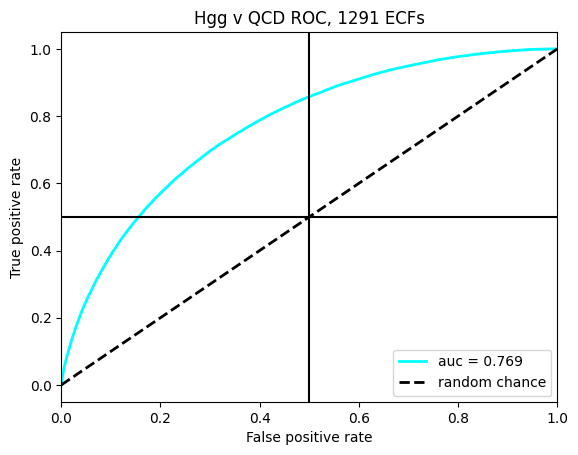

In [46]:
plt.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
plt.xlim([0, 1.0])
#     ax.set_ylim([1e-5, 1.0])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(f"Hgg v QCD ROC, {ratios} ECFs")
plt.legend(loc="lower right")
plt.axvline(x=0.5, color='black')
plt.axhline(y=0.5, color='black')
# for i in wp_ratios:
#     plt.plot(wp_ratios[i][1], wp_ratios[i][0], 'o', label=f'WP = {float(i):.1f}')
plt.legend(bbox_to_anchor=(0.655,0.16))
plt.savefig(f'rocs/tagger_{ratios}.png', bbox_inches='tight')
plt.show()

In [26]:
output = {}
output['fpr'] = fpr.tolist()
output['tpr'] = tpr.tolist()
output['auc'] = roc_auc

In [27]:
with open(f'roc_jsons/{ratios}.json', 'w') as f:
    json.dump(output, f)

In [28]:
def get_percentile_cut(data, target_percentile=0.10):
    data = np.array(data)
    cut_value = np.percentile(data, (1 - target_percentile) * 100)
    return cut_value

In [29]:
cut = get_percentile_cut(hgg.hgg_scores)
cut

0.8130935907363892

In [30]:
mask = ~((qcd['qcd_scores'] >= cut))
qcd_cut_msd = qcd.msoftdrop[mask]
qcd_fail_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='QCD MSD').Weight()
qcd_fail_hist.fill(msd=qcd_cut_msd);

In [31]:
mask = ((qcd['qcd_scores'] >= cut))
qcd_cut_msd = qcd.msoftdrop[mask]
qcd_pass_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='QCD MSD').Weight()
qcd_pass_hist.fill(msd=qcd_cut_msd);

In [32]:
with open('/afs/crc.nd.edu/user/c/cmoore24/Public/hgg/ecfs/ecf_resources/jsons/subregion_event_totals.json', 'r') as f:
    totals = json.load(f)
with open('/afs/crc.nd.edu/user/c/cmoore24/Public/hgg/ecfs/ecf_resources/jsons/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [33]:
total_qcd_hist = qcd_pass_hist + qcd_fail_hist

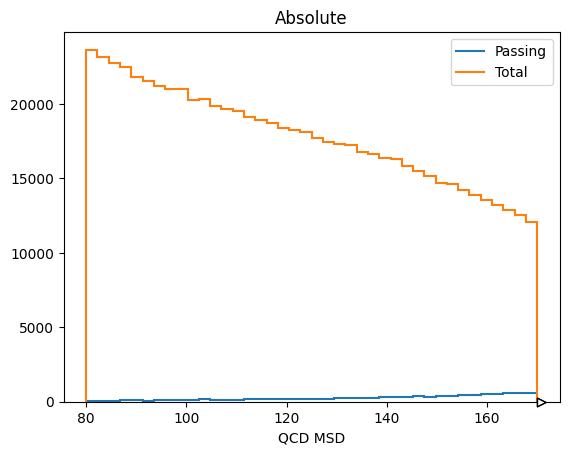

In [34]:
qcd_pass_hist.plot1d(density=False, label='Passing', yerr=False)
total_qcd_hist.plot1d(density=False, label='Total', yerr=False)
plt.title('Absolute')
plt.legend()
plt.show()

In [35]:
sum(qcd_pass_hist.values()), sum(total_qcd_hist.values())

(10143.0, 713663.0)

In [36]:
sum(qcd_pass_hist.values())/sum(total_qcd_hist.values()) * 100

1.421259053642966

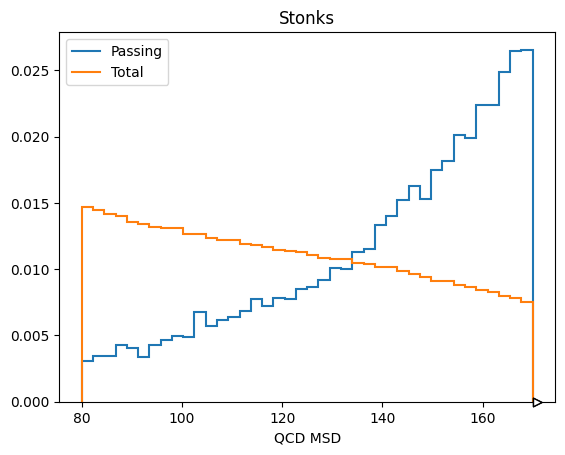

In [37]:
qcd_pass_hist.plot1d(density=True, label='Passing', yerr=False)
total_qcd_hist.plot1d(density=True, label='Total', yerr=False)
plt.title('Stonks')
#plt.yscale('log')
plt.legend()
#plt.axvline(x=560)
plt.show()

In [38]:
mask = ~((hgg['hgg_scores'] >= cut))
hgg_cut_msd = hgg.msoftdrop[mask]
hgg_fail_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='Hgg MSD').Weight()
hgg_fail_hist.fill(msd=hgg_cut_msd);

In [39]:
mask = ((hgg['hgg_scores'] >= cut))
hgg_cut_msd = hgg.msoftdrop[mask]
hgg_pass_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='Hgg MSD').Weight()
hgg_pass_hist.fill(msd=hgg_cut_msd);

In [40]:
scaleHgg = ((44.99*(xsecs['hgg']*1000)*0.0817)/(totals['hgg']))
hgg_fail_hist.view(flow=True)[:] *= scaleHgg
hgg_pass_hist.view(flow=True)[:] *= scaleHgg

In [41]:
total_hgg_hist = hgg_pass_hist + hgg_fail_hist

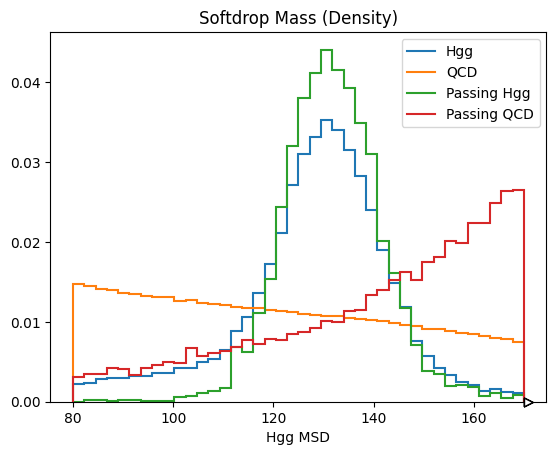

In [42]:
total_hgg_hist.plot1d(density=True, label='Hgg', yerr=False)
total_qcd_hist.plot1d(density=True, label='QCD', yerr=False)
hgg_pass_hist.plot1d(density=True, label='Passing Hgg', yerr=False)
qcd_pass_hist.plot1d(density=True, label='Passing QCD', yerr=False)
plt.title('Softdrop Mass (Density)')
plt.legend()
plt.show()

In [43]:
sum(hgg_pass_hist.values()), sum(total_hgg_hist.values())

(2.919214169179304, 29.19069438680088)

In [44]:
feature_strength = bst.get_score(importance_type="gain")
feature_strength_full = {f: feature_strength.get(f, 0.0) for f in feature_names}

In [45]:
sorted_by_values = dict(sorted(feature_strength_full.items(), key=lambda item: item[1]))

In [ ]:
# with open('mc_strengths_jsons/ecf_tagger_strengths_75.json', 'w') as f:
#     json.dump(feature_strength_full, f)